Let us look at an example from Statistical Mechanics now. The goal of this notebook is to make the concepts of in-sample and out-of-sample errors, as well as $L^2$- and $L^1$-regularisation more intuitive from a physicists perspective. Below, we demonstrate that...

Consider the 2D Ising model with nearest-neighbour interactions 

$$H=-J\sum_{m,n=1}^L S_{m,n}S_{n+1,n}+S_{m,n}S_{m,n+1}$$

on a $L\times L$ square lattice with $S_{m,n}=\pm 1$ the Ising spin variables. We use periodic boundary condtions. This paradigmatic model has a phase transition at the critical temperature $T_c\approx ...$ from an ordered antiferromagnetic to a disordered phase. Since the physics of this model is taught in every Statistical Mechanics textbook, we assume the reader is familiar with it, and focus here on the Machine Learning aspects instead. 

Suppose your boss set $J=1$, drew a large number of spin states at the temperature $T/J=3.0$, and computed their Ising energies. Then, without telling you about the above Hamiltonian, they just give you this data set. Your task is to learn the Hamiltonian using Linear regression techniques. 

In [23]:
import numpy as np
import scipy.sparse as sp

### define Ising model aprams
# system size
Lx=10
Ly=10
# temperature
T=3.0

def ising_energies(states,Lx,Ly):
	"""
	This function calculates the energies of the states in the nn Ising Hamiltonian
	"""
	J=np.zeros((Lx,Ly,Lx,Ly),)
	for i in range(Lx):
		for j in range(Ly):
			for kl in [[1,0],[0,1]]: #[[0,-1],[1,0],[0,1],[-1,0]]:
					J[i,j,(i+kl[0])%Lx,(j+kl[1])%Ly]-=1.0
	J=J.reshape(Lx*Ly,Lx*Ly)
	# compute energies
	E = np.einsum('...i,ij,...j->...',states,J,states)

	return E

### load data
states_str = "mag_vs_T_L%i_T=%.2f.txt" %(Lx,T)
states=np.loadtxt(states_str,delimiter=",",dtype=np.int)
states[np.where(states==0)]=-1 # replace 0 by -1
# compute energies
energies=ising_energies(states,Lx,Ly)

First of all, we have to decide for a model class. With no prior knowledge about which Ising model the data comes from, one respectful candidate is the all-to-all Ising model

$$H_\mathrm{model}[S^i] = - \sum_{m,n=1}^L \sum_{k,l=1}^L J_{mn,kl}S_{m,n}^iS_{k,l}^i =\mathbf{X}^i \cdot \mathbf{J}$$

uniquely defined by the non-local coupling strengths $J_{mn,kl}$ which we want to learn. Thus, the model we chose is linear in $J$ which renders the application of linear regression feasible. This motivates casting $H_\mathrm{model}[S^i]$ in the above form, where the vectors $\mathbf{X}^i$ represent all two-body interactions $\{S_{m,n}^iS_{k,l}^i \}_{m,n,k,l=1}^L$, and the index $i$ runs over the samples in the data set. To make the analogy complete, we can also represent the dot product by a single index $p = \{m,n,k,l\}$, i.e. $\mathbf{X}^i \cdot \mathbf{J}=X^i_pJ_p$. Note that the regression model des no include the minus sign, so we expect to learn negative $J$'s.

In [24]:
# reshape Ising states into RL samples: S_iS_j --> X_p
states=np.einsum('...i,...j->...ij', states, states)
shape=states.shape
states=states.reshape((shape[0],shape[1]*shape[2]))
# build final data set
Data=[states,energies]

As we already mentioned a few times in the review, learning is not fitting: the subtle difference is that once we fit the data to obtain a candidate model, we expect it to generalise on so far unseen data. Thus, we begin by specifying a training and test data sets

In [72]:
# define number of samples
n_samples=1000
# define train and test data sets
X_train=Data[0][:n_samples]
Y_train=Data[1][:n_samples] #+ np.random.normal(0,4.0,size=X_train.shape[0])
X_test=Data[0][n_samples:3*n_samples/2]
Y_test=Data[1][n_samples:3*n_samples/2] #+ np.random.normal(0,4.0,size=X_test.shape[0])

We can now apply Ordinary Least Squares, Ridge regression and Lasso. 

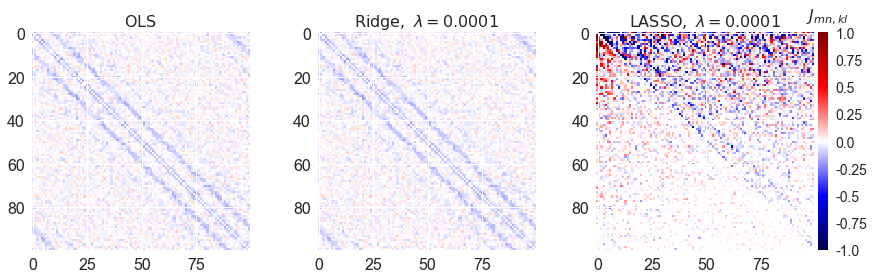

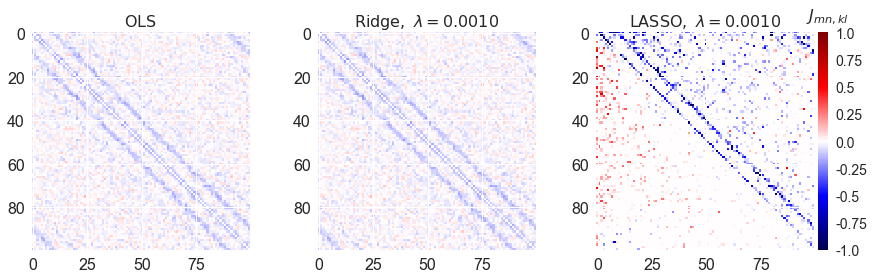

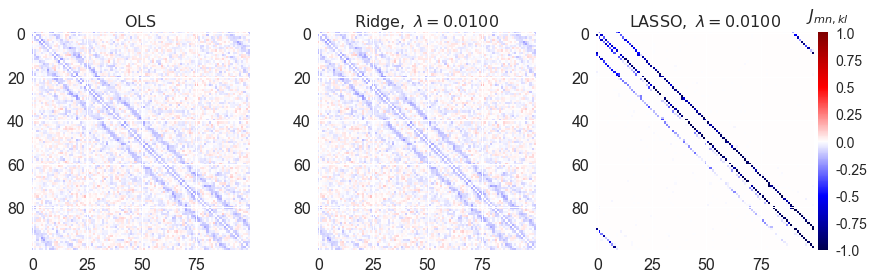

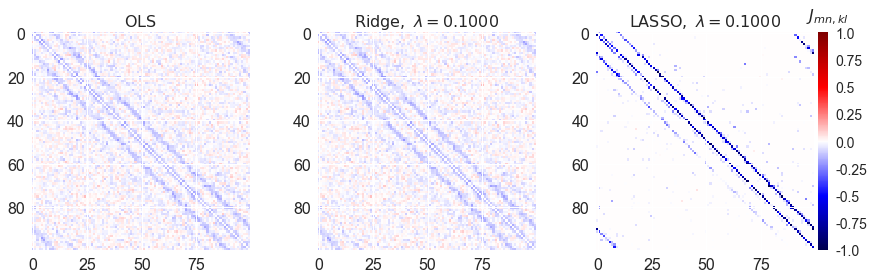

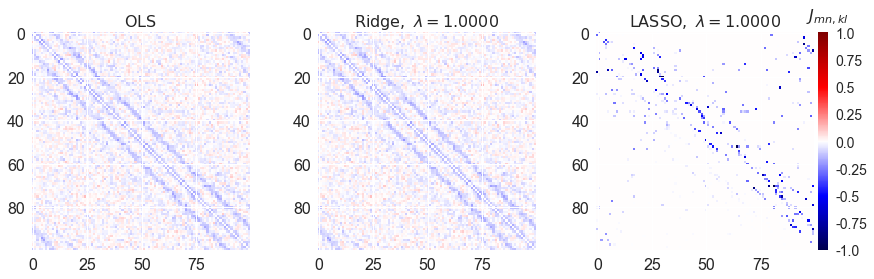

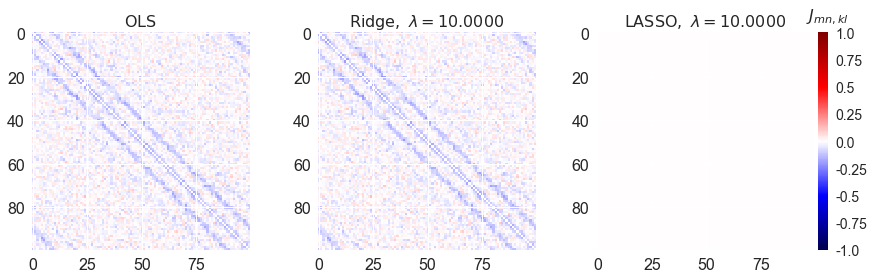

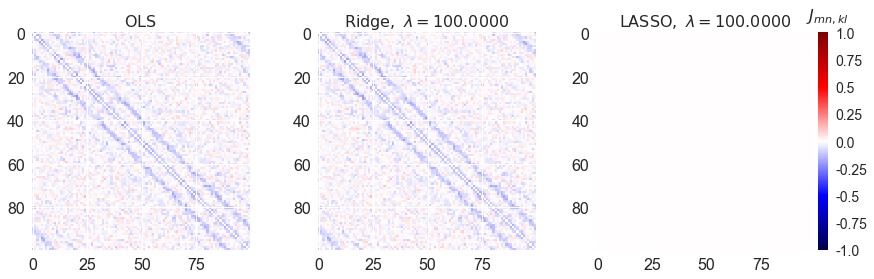

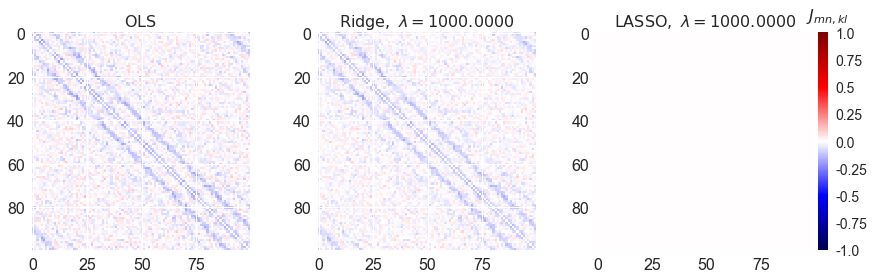

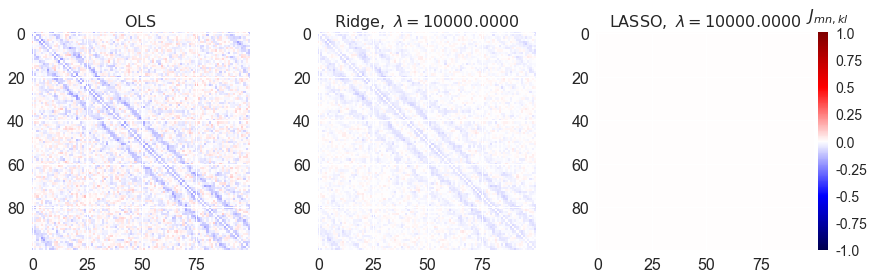

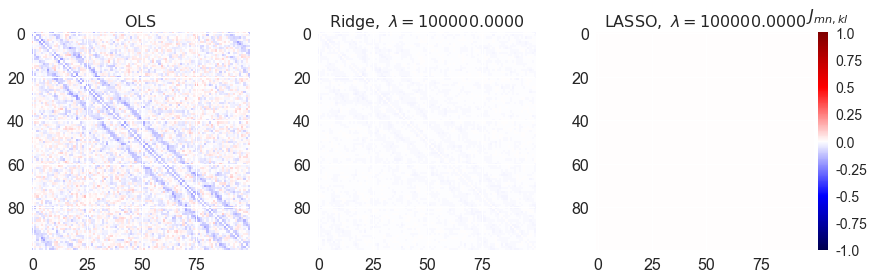

In [73]:
from sklearn import linear_model
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn
%matplotlib inline

# set up Lasso and Ridge Regression models
leastsq=linear_model.LinearRegression()
ridge=linear_model.Ridge()
lasso = linear_model.Lasso()

# define error lists
train_errors_leastsq = []
test_errors_leastsq = []

train_errors_ridge = []
test_errors_ridge = []

train_errors_lasso = []
test_errors_lasso = []

# set refularisations trength values
lmbdas = np.logspace(-4, 5, 10)

#Initialize coeffficients for ridge regression and Lasso
coefs_leastsq = []
coefs_ridge = []
coefs_lasso=[]

for lmbda in lmbdas:
    
    ### ordinary least squares
    leastsq.fit(X_train, Y_train) # fit model 
    coefs_leastsq.append(leastsq.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_leastsq.append(leastsq.score(X_train, Y_train))
    test_errors_leastsq.append(leastsq.score(X_test,Y_test))
    
    ### apply Ridge regression
    ridge.set_params(alpha=lmbda) # set regularisation parameter
    ridge.fit(X_train, Y_train) # fit model 
    coefs_ridge.append(ridge.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_ridge.append(ridge.score(X_train, Y_train))
    test_errors_ridge.append(ridge.score(X_test,Y_test))
    
    ### apply Ridge regression
    lasso.set_params(alpha=lmbda) # set regularisation parameter
    lasso.fit(X_train, Y_train) # fit model
    coefs_lasso.append(lasso.coef_) # store weights
    # use the coefficient of determination R^2 as the performance of prediction.
    train_errors_lasso.append(lasso.score(X_train, Y_train))
    test_errors_lasso.append(lasso.score(X_test,Y_test))


    ### plot Ising interaction J
    J_leastsq=np.array(leastsq.coef_).reshape((Lx,Ly,Lx,Ly))
    J_ridge=np.array(ridge.coef_).reshape((Lx,Ly,Lx,Ly))
    J_lasso=np.array(lasso.coef_).reshape((Lx,Ly,Lx,Ly))

    cmap_args=dict(vmin=-1., vmax=1., cmap='seismic')

    fig, axarr = plt.subplots(nrows=1, ncols=3)
    
    axarr[0].imshow(J_leastsq.reshape(Lx*Ly,Lx*Ly),**cmap_args)
    axarr[0].set_title('$\\mathrm{OLS}$',fontsize=16)
    axarr[0].tick_params(labelsize=16)
    
    axarr[1].imshow(J_ridge.reshape(Lx*Ly,Lx*Ly),**cmap_args)
    axarr[1].set_title('$\\mathrm{Ridge},\ \\lambda=%.4f$' %(lmbda),fontsize=16)
    axarr[1].tick_params(labelsize=16)
    
    im=axarr[2].imshow(J_lasso.reshape(Lx*Ly,Lx*Ly),**cmap_args)
    axarr[2].set_title('$\\mathrm{LASSO},\ \\lambda=%.4f$' %(lmbda),fontsize=16)
    axarr[2].tick_params(labelsize=16)
    
    divider = make_axes_locatable(axarr[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar=fig.colorbar(im, cax=cax)
    
    #print(dir(cbar.ax))
    
    cbar.ax.set_yticklabels(np.arange(-1.0, 1.0+0.25, 0.25),fontsize=14)
    cbar.set_label('$J_{mn,kl}$',labelpad=-40, y=1.12,fontsize=16,rotation=0)
    
    fig.subplots_adjust(right=2.0)
    
    plt.show()

To quantify learning, we also plot the in-sample and out-of-sample errors

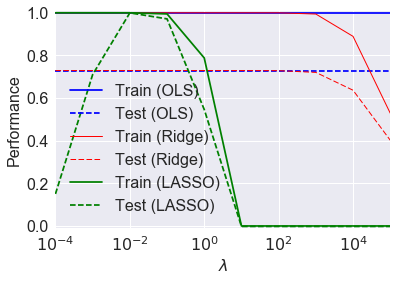

In [29]:
# Plot our performance on both the training and test data
plt.semilogx(lmbdas, train_errors_leastsq, 'b',label='Train (OLS)')
plt.semilogx(lmbdas, test_errors_leastsq,'--b',label='Test (OLS)')
plt.semilogx(lmbdas, train_errors_ridge,'r',label='Train (Ridge)',linewidth=1)
plt.semilogx(lmbdas, test_errors_ridge,'--r',label='Test (Ridge)',linewidth=1)
plt.semilogx(lmbdas, train_errors_lasso, 'g',label='Train (LASSO)')
plt.semilogx(lmbdas, test_errors_lasso, '--g',label='Test (LASSO)')


#plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
#           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left',fontsize=16)
plt.ylim([-0.01, 1.01])
plt.xlim([min(lmbdas), max(lmbdas)])
plt.xlabel(r'$\lambda$',fontsize=16)
plt.ylabel('Performance',fontsize=16)
plt.tick_params(labelsize=16)
plt.show()

Let us ake a few remarks: (i) the regularisation parameter $\lambda$ which affects the Ridge and LASSO regressions at scales, sperated by a few orders of magnitude. Notice that this is different for the data considered in Notebook 2. Thus, it is a considered good practice to always check the performance for the given model and data. (ii) at $\lambda\to 0$ and $\lambda\to\infty$, all three models overfit the data, as can be seen from the deviation of the test errors from unity (dashed lines), while the training curves stay at unity. (iii) While the OLS and Ridge regression test curves are monotonic, the LASSO test curve is not -- suggesting the optimal LASSO reglarsation parameter is $\lambda\approx 10^{-2}$. At this sweet spot, the Ising interaction weights ${\bf J}$ contain only nearest-neighbour terms (as did the model the data was generated from).

Gauge degrees of freedom: recall that the uniform nearest-neghbour interactions strength $J_{mn,kl}=J$ which we used to generate the data was set to unity, $J=1$. Morover, $J_{mn,kl}$ was NOT deined to be symmetric (we only used the $J_{mn,m+1n}$ but never the $J_{mn,m-1n}$ elements). The colorbar on the matrix elements plot suggest that the OLS and Ridge regression learn uniform symmetric weights $J=-0.5$. There is no mystery since this amounts to taking into account both the $J_{mn,m+1n}$ and the $J_{mn,m-1n}$ terms, and the weigts are distributed symemtrically between them. LASSO, on the other hand, can break this symmetry (see matrix elements plots for $\lambda=0.001$ and $\lambda=0.01$). Thus, we see how different regularisation schemes can lead to learning equivalent models but in different gauges. Any information we have about the symmetry of the unknown model that generated the data has to be reflected in the definition of the model and the regularisation.

### Excercises: ###  
<ul>
<li> Plot a histogram of the disstribution of the components of ${\bf J}$ at different values of the number of samples parameter (one can go up to $2\times 10^4$. What happens with the sampling noise as the number of samples is increased/decreased for the three types of regression considered? How does do the matrix elements plots above change?

</ul>